In [1]:
# importing once and for all the needed stuff...
import gzip, os, sys, cPickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize as optimize
from scipy.stats import norm as Gaussian_PDF
from my_foos import Lin_Log_Bins, Smooth_Curve, p_n_pow_const, Power_Growth

from matplotlib import rc
rc('font', family = 'serif', serif = 'Times')
rc('text', usetex = True)
from matplotlib.ticker import NullFormatter

%pylab inline
%matplotlib inline

sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in",\
    "xtick.major.size": 10, "ytick.major.size": 10,\
    "xtick.minor.size": 5,  "ytick.minor.size": 5,})

# Colors and plot-related stuff...
colori = ['#F44E21', '#28CE9A', '#1A91E2', '#585959','#BF2D19', '#A3CD39', '#39D5F1',\
        '#7F5271',  '#FF9A15', '#068C7F', '#206584', '#8CBBEA']
markers = ('o', '8', '^', '<', 'D', '*', 's', 'p', 'v', 'h', 'H', '>', 'd')

cmap_winter = matplotlib.cm.winter
cmap_autumn = matplotlib.cm.autumn
cmap_summer = matplotlib.cm.summer
cmap_spring = matplotlib.cm.spring
cmap_rb = matplotlib.cm.rainbow

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## If you want to analyze the data, here you go...

In [2]:
import Network_Importer as NII

In [ ]:
if False: #"PRL"
    dat_file_name = NII.Network_Importer("../../data/APS/data/data_company_like/L_60/",\
        "../../out/Prova_new_importer_PRL/", SOC_THR=0, step_by_step=False, n_t_smpl=50, starting_time=48,\
        time_events=False, zipped_f=False, act_bins_factor=1.2, deg_bins_factor=1.4)
elif False: #"TWT"
    dat_file_name = NII.Network_Importer("../../data/twitter/twitter/data-01-09_company_like/",\
        "../../out/Prova_new_importer_TWT_new/", SOC_THR=0, step_by_step=False, n_t_smpl=50,\
        time_events=True, zipped_f=False, act_bins_factor=1.3, deg_bins_factor=1.3)
elif True: #"APS" TOTAL
    dat_file_name = NII.Network_Importer("../../data/APS/aff_data_ISI_company_like_1960_2008/",\
        "../../out/APS_TOTAL/", SOC_THR=0, step_by_step=False, n_t_smpl=20, starting_time=1033,\
        time_events=False, zipped_f=False, act_bins_factor=1.25, deg_bins_factor=1.25, binning='act')
    

## Loading data...

First define the datafile to use as *dat_file_name*...

In [2]:
if True:
    dat_file_name = '../dataUrne_r06_n04/data/networkStats_a120_k120_e200_stBySt1_tScheve_bScheak.dat.gz'
DATA = cPickle.load(gzip.open(dat_file_name, 'rb'))

In [3]:
# Creating the needed dirs...
needed_dirs = ["P_akt", "kat", "pna", "chi_square"]
#####################################

BASE_DIR = os.path.split(dat_file_name)[0]
for dirn in needed_dirs:
    tmp_path = os.path.join(BASE_DIR, dirn)
    if not (os.path.exists(tmp_path) and os.path.isdir(tmp_path)):
        os.mkdir(tmp_path)

## The $p(k)$ reinforcement process

In [4]:
DATA.keys()

['Stats', 'pkt', 'Arrays', 'TimeVecs', 'Params', 'pna', 'Bins']

In [5]:
def minDeg(DATA, nodeClass):
    tmpBin = DATA["Bins"]["Bins"]
    binningScheme = DATA["Params"]["binningScheme"]
    for i in range(binningScheme.index("k")):
        tmpBin = tmpBin["v"][nodeClass[i]]
    return tmpBin["b"][nodeClass[i+1]]

In [9]:
################################################
# Threshold: a point must have at least thres-events, thres new events and
# a difference between the two of at least thres to be accounted for...
Threshold = 5

# Minimum number of valid points for a curve to be fitted...
Nmin = 5

# Function that returns the mother class(es) to be used for a single pna plot
currentSuperClass = lambda classID: classID[:2]

# Factor smooting the curves...
smooth_factor = lambda v: (float(max(v))/max(1., min(v)))*.099

# Plotting settings...
print_legend = True
markers_size = 10
ax_fsize, lbl_fsize, lgnd_fsize = 16, 22, 10
figsize=(5,4)
################################################

In [10]:
# Here we save all the curves for the later fitting procedure and heat-map...
Pn_Curves = {}
pna = DATA['pna']

# We plot the p(n,a)
lastClass = None
some_plot = False
plotCount, classCount = 0, 0
for nodeClass, pni in sorted(pna.items()):
    print "\r", nodeClass, classCount+1, len(pna), "                        ",
    classCount += 1
    
    if lastClass != currentSuperClass(nodeClass):
        if some_plot:
            plt.xticks(size=ax_fsize)
            plt.yticks(size=ax_fsize)
            plt.xlabel(r"$k$", size=lbl_fsize)
            plt.ylabel(r"$p(k\to k+1)$", size=lbl_fsize)

            if print_legend:
                plt.legend(loc=1, fontsize=lgnd_fsize, ncol=1)
            plt.tight_layout()
            plt.savefig(os.path.join(BASE_DIR, "pna/p_n_%s.pdf" % "-".join("%d" % i for i in nodeClass)),\
                                bbox_inches='tight')
            plt.close(fig_tmp)
        
        lastClass = currentSuperClass(nodeClass)
        some_plot = False
        plotCount = 0
        fig_tmp = plt.figure(figsize=figsize)        


    valid_degs = [k for k, evs in sorted(pni.items())\
                 if evs['s_new'] >= Threshold and evs['s_eve'] >= Threshold\
                 and (evs['s_eve'] - evs['s_new']) >= Threshold\
                 and float(k) <= minDeg(DATA, nodeClass)]

    X = np.array([float(k) for k in valid_degs])
    Y = np.array([float(pni[k]['s_new'])/float(pni[k]['s_eve']) for k in valid_degs])

    # Cleaning the zeroes...
    X = X[Y>.0]
    Y = Y[Y>.0]

    # Computing the uncertainity on the measured $p(k)$...
    STD_err = np.array([((Y[i]*(1.-Y[i]))/float(pni[k]['s_eve']))**.5\
                        for i,k in enumerate(valid_degs)])

    if len(X) > Nmin:
        some_plot = True
        X_plot, Y_plot = Smooth_Curve(X, Y, factor=smooth_factor(X))
        plt.loglog(X_plot,Y_plot, '--', marker=markers[plotCount%len(markers)], ms=markers_size,\
                   label=".".join("%d"%i for i in nodeClass), alpha=.9)

        Pn_Curves[nodeClass] = {'x': X, 'y': Y, 'w': STD_err, 'x_smooth': X_plot, 'y_smooth': Y_plot}
        plotCount += 1
        
if some_plot:
    plt.xticks(size=ax_fsize)
    plt.yticks(size=ax_fsize)
    plt.xlabel(r"$k$", size=lbl_fsize)
    plt.ylabel(r"$p(k\to k+1)$", size=lbl_fsize)

    if print_legend:
        plt.legend(loc=1, fontsize=lgnd_fsize, ncol=1)
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "pna/p_n_%s.pdf" % "-".join("%d" % i for i in nodeClass)),\
                        bbox_inches='tight')
    plt.close(fig_tmp)

(0, 51, 0) 210 1177                               80 1177                              111 1177                                  

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(9, 6, 0) 1177 1177                           177                                 1177                                                            1177                                                                                                630 1177                                                                     1177                           833 1177                             1177                                 1177                                                                        1177                            


In [35]:
################################################
# Select a single multi-activity, non fitted curves...

selectCriterion = lambda classID: classID[:1]
selectedMultiClasses = [(9,), (11,), (13,)]

some_plot = False
fig_tmp = plt.figure(figsize=figsize)
for nodeClass, pni in sorted(Pn_Curves.items()):
    if selectCriterion(nodeClass) not in selectedMultiClasses:
        continue
    some_plot = True

    X_plot, Y_plot = pni["x_smooth"], pni["y_smooth"]

    plt.loglog(X_plot,Y_plot, '--', ms=markers_size, alpha=.9,\
        marker=markers[(sum(nodeClass)*(nodeClass[0]+1))%len(markers)])

if some_plot:
    plt.xticks(size=ax_fsize)
    plt.yticks(size=ax_fsize)
    plt.xlabel(r"$k$", size=lbl_fsize)
    plt.ylabel(r"$p(k)$", size=lbl_fsize)

    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR,\
        "pna/p_n_multiA_%s.pdf" % "_".join(["-".join("%d"%c for c in cl) for cl in selectedMultiClasses])),
        bbox_inches='tight')

plt.close(fig_tmp)

## Now we compute the optimal $\beta$, then plotting the fitted $p(k\to k+1)$ with the total rescaled one...

In [11]:
################################################
# Beta interval to sweep...
Beta_int = np.arange(.0, 3.51, .01)

# Fixed beta overall or use the optimal beta for each bin...
Fixed_Beta = True

# setting bounds for c...
const_bounds = (1e-4, 1e+4)

# Plotting stuff...
Show_Legend = True
n_points_Pc = 8

################################################

Tot_Chi_Sums = np.zeros(len(Beta_int), dtype=float)
opt_pars = {b: {nc: [] for nc, _ in Pn_Curves.items()} for b in Beta_int}
Chi_Sums = {b: {nc: .0 for nc, _ in Pn_Curves.items()} for b in Beta_int}

for ii_ind, bb_val in enumerate(Beta_int):
    opt_params = np.array([bb_val, 2.])
    opt_bounds = [(bb_val*.9999, bb_val*1.0001), const_bounds]

    sum_chi_temp, sum_pop_temp, pts_pop_temp = .0, .0, .0
    for nodeClass, classDict in sorted(Pn_Curves.items()):
        nn = classDict['x']
        pn = classDict['y']
        wn = classDict['w']

        par_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(p_n_pow_const, x0 = opt_params,\
                args=(nn, pn, wn), bounds=opt_bounds, approx_grad=True,\
                maxfun=1000000, maxiter=1000000)

        print "\rOptimization for bin a%s done with exit status %d: beta %.02f - cnst %.02f - chi2 %.02e"%\
            (".".join("%d" % c for c in nodeClass), dic_out['warnflag'], par_out[0], par_out[1], chi2_tmp),

        # Saving the summed chi square...
        sum_chi_temp += chi2_tmp
        sum_pop_temp += DATA['Bins']['N_A_K'][nodeClass]
        pts_pop_temp += float(len(nn) - 1)

        # Saving the constant and the chi_squared...
        opt_pars[bb_val][nodeClass] = [v for v in par_out]
        Chi_Sums[bb_val][nodeClass] = chi2_tmp

    if sum_pop_temp != .0:
        # We normalize by the number of fitted points, indeed this will be
        # the same number for every beta (we always fit the same curves!).
        Tot_Chi_Sums[ii_ind] = sum_chi_temp/pts_pop_temp

print "\n"

Ind_Bopt = np.argmin(Tot_Chi_Sums)
Beta_Opt = Beta_int[Ind_Bopt]
print 'beta_opt_act=%.02f' % Beta_Opt

Optimization for bin a8.7.4 done with exit status 0: beta 3.50 - cnst 19.88 - chi2 2.32e+00                                                                                                                                                                                                                                                                                                                                                                                                                  

beta_opt_act=1.06


In [12]:
# Select the aggregator of classes...
currentSuperClass = lambda classID: classID[:1]
selectedSuperClasses = [(i,) for i in range(30)]

# x axis limit (set to None for free plot)
xlim = (1e4, 4e6)
ylim = (1e1, 1e3)

In [13]:
##################################################
# Now plotting the distribution of the optimized #
# constant for each activity class...            #
##################################################

fig_Pconst = plt.figure()

# The containers for the cumulative (overall) distribution of P(c)...
TOT_cs = []
TOT_ns = []

for superClass in selectedSuperClasses:
    validClasses = [classId for classId in Pn_Curves.keys() if currentSuperClass(classId) == superClass]
    if not validClasses: continue
        
    constVals, popVals = [], []
    for nodeClass in validClasses:
        optBetaValue = Beta_Opt if Fixed_Beta else np.argmin([Chi_Sums[b][nodeClass] for b in Beta_int])
        constVals.append(opt_pars[optBetaValue][nodeClass][1])
        popVals.append(DATA["Bins"]["N_A_K"][nodeClass])
        
        TOT_cs.append(opt_pars[optBetaValue][nodeClass][1])
        TOT_ns.append(DATA["Bins"]["N_A_K"][nodeClass])
    constVals, popVals = np.array(constVals), np.array(popVals)
    if len(np.unique(constVals)) <= 1: continue
        
    Y, X = np.histogram(constVals, weights=popVals, density=True, bins=\
        np.logspace(np.log10(max(const_bounds[0], constVals.min())),\
                    np.log10(min(const_bounds[1], constVals.max())), n_points_Pc))
    X = (X[1:] + X[:-1])/2.
    X = X[Y>.0]
    Y = Y[Y>.0]
    plt.loglog(X, Y,'--', alpha=.8,\
               marker=markers[selectedSuperClasses.index(superClass)%len(markers)],\
               label=".".join("%d"%c for c in superClass))
    
# Then plotting the overall distribution...
YY, XX = np.histogram(TOT_cs, weights=TOT_ns, density=True, bins=\
    np.logspace(np.log10(max(const_bounds[0],min(TOT_cs))), np.log10(min(const_bounds[1],max(TOT_cs))), n_points_Pc))
XX = (XX[1:] + XX[:-1])/2.
XX = XX[YY>.0]
YY = YY[YY>.0]
plt.loglog(XX, YY, '-', lw=4, color='#068C7F', label='All')    
    
if Show_Legend:
    plt.legend(loc=3, fontsize=lgnd_fsize, ncol=2)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'chi_square/P_c.pdf'), bbox_inches='tight')
plt.close(fig_Pconst)

In [11]:
##################################################
# Now plotting the fitted p(n) for each activity #
# class and the total rescaled plot...           #
##################################################

# Selected activity classes for the overall rescaled p(k) function...
Sel_acts = range(4, 16, 2)

########################################################

fig_pn_tot = plt.figure(1, figsize=figsize)
resc_lim = [1000, .01]
for ak, act_dic in sorted(Pn_Curves.items()):
    fig_tmp = plt.figure(2, figsize=figsize)
    for dk, pni in sorted(act_dic.items()):
        if dk in []:
            continue
        fig_tmp = plt.figure(2)
        serie_tmp = plt.loglog(pni['x_smooth'], pni['y_smooth'],\
                   linestyle='', marker=markers[dk%len(markers)], ms=markers_size, alpha=.9)
        
        XX = np.logspace(.0, np.log10(max(pni['x'])), 50)
        plt.loglog(XX, p_n_pow_const(opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk], XX),\
                   '-', lw=2, alpha=.75, color=serie_tmp[0].get_c())
        
        if ak in Sel_acts:
            plt.figure(1)
            XX = pni['x_smooth']/opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk][1]
            YY = pni['y_smooth']**(1./opt_pars[Optimal_Beta_bin[ak][dk]['beta']][ak][dk][0])
            plt.loglog(XX, YY, marker=markers[(ak*(dk+1))%len(markers)], ms=markers_size, alpha=.9)
            if max(XX) > resc_lim[1]: resc_lim[1] = max(XX)
            if min(XX) < resc_lim[0]: resc_lim[0] = min(XX)
            
    plt.figure(2)
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, 'pna/p_n_fit_%02d.pdf' % ak), bbox_inches='tight')
    plt.close(fig_tmp)

plt.figure(1)
XXX = np.logspace(np.floor(np.log10(resc_lim[0])), np.ceil(np.log10(resc_lim[1])), 100)
plt.loglog(XXX, 1./(1. + XXX), '-k', lw=4, alpha=.85, label=r"$(1+x)^{-1}$")

plt.xticks(size=ax_fsize)
plt.yticks(size=ax_fsize)
plt.xlabel(r"$x=k/c_i$", size=lbl_fsize)
plt.ylabel(r"$p(x)^{1/\beta}$", size=lbl_fsize)

plt.legend(loc=3, fontsize=lbl_fsize, ncol=1)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'pna/all_p_n.pdf'), bbox_inches='tight')
plt.close(fig_pn_tot)

In [12]:
##################################################
# Now plotting the fitted p(n) for a selected    #
# activity class with single beta for each bin.  #
##################################################

# Selected activity classes for the overall rescaled p(k) function...
Sel_act = 8
Discarded_ks = []

########################################################

fig_pn_tot = plt.figure(1, figsize=figsize)
fig_tmp = plt.figure(2, figsize=figsize)
act_dic = Pn_Curves[Sel_act]
FirstPlot = True
for dk, pni in sorted(act_dic.items()):
    print dk
    if dk in Discarded_ks:
        continue
        
    label = r"$\beta = " if FirstPlot else r"  $"
    if FirstPlot: FirstPlot = False
    label += r"%.01f$" % Optimal_Beta_bin[Sel_act][dk]['beta']
    
    serie_tmp = plt.loglog(pni['x_smooth'], pni['y_smooth'],\
               linestyle='', marker=markers[dk%len(markers)], ms=markers_size, alpha=.9, label=label)

    
    XX = np.logspace(.0, np.log10(max(pni['x'])), 50)
    
    
    plt.loglog(XX, p_n_pow_const(opt_pars[Optimal_Beta_bin[Sel_act][dk]['beta']][Sel_act][dk], XX),\
               '-', lw=2, alpha=.75, color=serie_tmp[0].get_c())

plt.xticks(size=ax_fsize)
plt.yticks(size=ax_fsize)
plt.xlabel(r"$k$", size=lbl_fsize)
plt.ylabel(r"$p(k)$", size=lbl_fsize)

frame = plt.legend(loc=3, fontsize=(lbl_fsize*4/5), ncol=4, handlelength=.25, numpoints=1,\
          columnspacing=.5, handletextpad=.7, framealpha=1., frameon=True)
frame = frame.get_frame()
frame.set_color('white')
frame.set_facecolor('white')
frame.set_edgecolor('white')

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'pna/p_n_fit_bs_%02d.pdf' % Sel_act), bbox_inches='tight')
plt.close()

1
2
3
4
5


## ... and now the heatmap with bands...

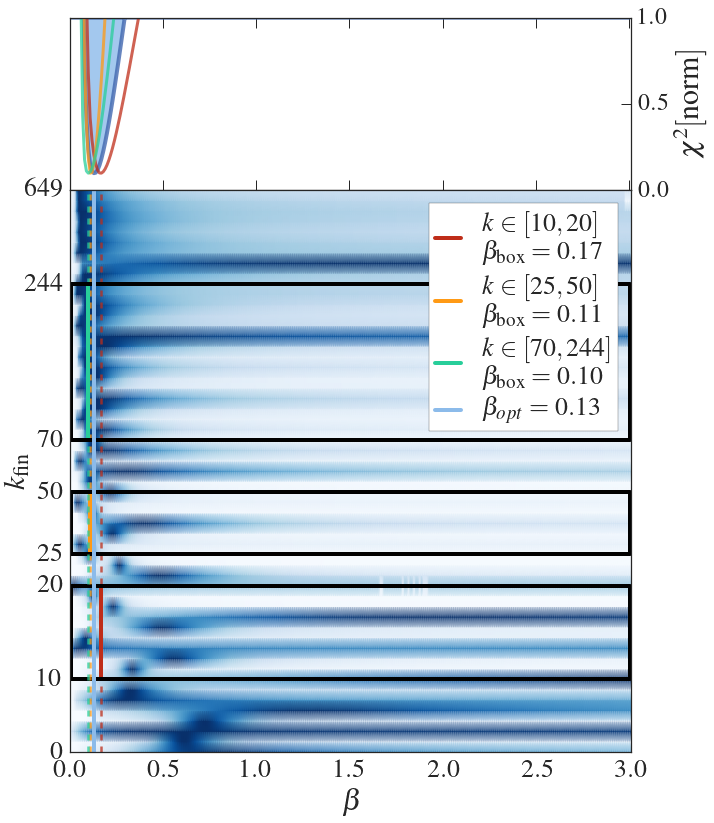

In [13]:
######################################
# The boxes to show the various betas...
#Boxes_lim = [[10,20], [40,80]] # PRA
#Boxes_lim = [[10,20], [25,50], [70, 300]] # PRB
#Boxes_lim = [[10,20], [20, 50]] # PRD
#Boxes_lim = [[7,15], [15,60]] # PRE
#Boxes_lim = [[10,20], [20,150]] # PRL
#Boxes_lim = [[10,25], [30,60], [80, 400]] # TWT
#Boxes_lim = [[10,20], [30,60], [90, 294]] # MPN
Boxes_lim = [[10,20], [25,50], [70, 244]] # APS entrance

# Whether or not to plot a guide to the eye...
Plot_Diag = False
diag_beta = [2.4, 1.2]
diag_degs = [0, 293]

# The program will rescale the curves between ValMin and ValMax so
# as to compare them...
ValMax = 1.
ValMin = .1

######################################
#Plot stuff (here we have a little more things ;) )
###################################### You should not touch the stuff here :)
left, bottom, width, height = .1, .1, .65, .65 # The rectangulum position and size for the HM
bottom_h = bottom + height
rect_HM = [left, bottom, width, height]
rect_X2 = [left, bottom_h, width, .2]

fig_tot = plt.figure(1, figsize=(12,12))
axX2 = plt.axes(rect_X2)
axX2.xaxis.set_major_formatter(NullFormatter())
axHM = plt.axes(rect_HM)

CMPS = ['Oranges', 'Reds', 'Greens']
Colors = ['#BF2D19', '#FF9A15', '#28CE9A']
Color_Tot = '#8CBBEA'
###################################### End of plot stuff...
Map_Original = np.zeros((sum([len(act_dic) for act_dic in Chi_Sums[Beta_int[0]].values()]), len(Beta_int)),\
                        dtype=float)
Kmins = np.zeros(Map_Original.shape[0], dtype=float)
row = 0
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm, Normalize
for ak, act_dic in Chi_Sums[Beta_int[0]].items():
    for dk, deg_dic in act_dic.items():
        Map_Original[row] = np.array([Chi_Sums[bb][ak][dk] for bb in Beta_int])
        Kmins[row] = DATA['ACT']['Bins']['kk'][ak][dk]
        row += 1
ISkmin = np.argsort(Kmins)
Map_Original = Map_Original[ISkmin][:]
Kmins = Kmins[ISkmin]

DeltaVal = ValMax - ValMin

if False:
    # Now rescale the map so that the curves are comparable...
    # Lower the minimum to zero for all the rows...
    Map_Rescaled = Map_Original - np.array([[min_row]*Map_Original.shape[1] for min_row in Map_Original.min(axis=1)])
    # Set 1. as a reference in the far right of the map for each row...
    Map_Rescaled /= np.array([[row[-5] if row[-5]>row_val else 1. for row_val in row] for row in Map_Rescaled])
    # Rescale and shift...
    Map_Rescaled *= DeltaVal
    Map_Rescaled += ValMin
    Map_Rescaled = -np.log10(Map_Rescaled)
else:
    Map_Rescaled = Map_Original / np.array([[min_row]*Map_Original.shape[1] for min_row in Map_Original.min(axis=1)])
    Map_Rescaled **= -1.
    

#figHM = axHM.pcolormesh(Map_Rescaled, cmap='Blues', norm=Normalize(), edgecolors='none', shading='gouraud')
figHM = axHM.pcolormesh(Map_Rescaled, cmap='Blues', norm=Normalize(), edgecolors='none', shading='gouraud')

#axHM.plot([300, 120], [0, len(Kmins)], '--', lw=5, alpha=.9, color='#FCDD2B')

#plt.colorbar(figHM)

tot_chi2_curve = Tot_Chi_Sums/Tot_Chi_Sums.min()/1.1
tot_chi2_curve -= min(tot_chi2_curve) - .1
axX2.fill_between(np.arange(len(Beta_int)), tot_chi2_curve, 1.,\
                color=Color_Tot, lw=4, alpha=.8, edgecolor='#4167af')

y_labels = [(0,0), (len(Kmins)-1, Kmins[-1])]
for boxi, box_edges in enumerate(Boxes_lim):
    if box_edges[0] < Kmins[0] or box_edges[1] > Kmins[-1]:
        print "Ignoring box ", box_edges, " because it is out of bound: kmin = %d, kmax = %d" % (Kmins[0], Kmins[-1])
        continue
    tmp_chi2_curve = Map_Original[(Kmins>=box_edges[0]) & (Kmins<=box_edges[1])].sum(axis=0)
    tmp_chi2_curve /= tmp_chi2_curve.min()*1.1
    tmp_chi2_curve -= tmp_chi2_curve.min() - .1
    axX2.plot(np.arange(len(Beta_int)), tmp_chi2_curve,\
                     color=Colors[boxi], lw=3, alpha=.75)
    
    
    # The reference curve and the black box...
    box_bot = np.argmax(Kmins>=box_edges[0])
    box_top = np.argmin(Kmins<=box_edges[1])
    min_ind = np.argmin(tmp_chi2_curve)
    axHM.plot([min_ind]*2, [0, Map_Original.shape[0]-1], '--',\
              color=Colors[boxi], lw=2.5, alpha=.75)
    axHM.plot([min_ind]*2, [box_bot, box_top], '-', color=Colors[boxi],\
              lw=4, label=r'$k\in[%d, %d]$' '\n' r'$\beta_{\rm box}=%.02f$'%\
             (box_edges[0], box_edges[1], Beta_int[min_ind]))
    axHM.plot([1.,1.,len(Beta_int)-1.5, len(Beta_int)-1.5, 1.],\
        [box_bot, box_top, box_top, box_bot, box_bot], '-k', lw=4)
    
    y_labels.extend([(box_bot, box_edges[0]), (box_top, box_edges[1])])

if Plot_Diag:
    axHM.plot([np.argmax(Beta_int >= b) for b in diag_beta], [np.argmax(Kmins >= k) for k in diag_degs],\
              '--', lw=5, alpha=.9, color='#FCDD2B')
    
beta_labels = range(0, len(Beta_int), 50)
axHM.xaxis.set_ticks(beta_labels, minor=True)
axHM.xaxis.set_ticklabels([r"$%.01f$"%Beta_int[i] for i in beta_labels], size=26)
#axHM.xaxis.set_tick_params(which='both', direction='in', length=12, width=10, zorder=0)

axHM.set_yticks([ylab[0] for ylab in y_labels])
axHM.set_yticklabels([r"$%d$"%ylab[1] for ylab in y_labels], size=26)
    
axHM.plot([Ind_Bopt]*2, [0, len(Kmins)-1],\
        '-', color=Color_Tot, lw=4,\
        label=r'$\beta_{opt} = %.02f$' % (Beta_Opt))



axX2.set_ylim(0,1)
axX2.set_xlim(0,len(Beta_int))
#axHM.legend(fontsize=26, loc=3, bbox_to_anchor=(.00125,.00125), frameon=True, borderpad=.25, labelspacing=.25, handlelength=1.)
axHM.legend(fontsize=26, loc=1, frameon=True, borderpad=.25, labelspacing=.25, handlelength=1.)
axHM.set_ylim(0, len(Kmins)-1)
axHM.set_xlabel(r"$\beta$", size=30)
axHM.set_ylabel(r"$k_{\rm fin}$", size=30, labelpad=-10)


axX2.yaxis.tick_right()
axX2.axes.set_yticks([0., .5, 1.])
axX2.axes.set_yticklabels([r'$%.1f$' % c2v for c2v in [.0, .5, 1.]], size=24)
axX2.set_ylabel(r"$\chi^2[{\rm norm}]$", size=30)
axX2.yaxis.set_label_position("right")

fig_tot.savefig(os.path.join(BASE_DIR, "chi_square/Heat_Map_Bands.pdf"))#, bbox_inces="tight")

# ... now the $P(a,k,t)$...

    - Choose the activity classes to plot;
    - choose the time of reference;
    - choose the scaling picture expected (if no parameters are found);
    - select the times to be plotted as well...

In [14]:
# Select the aggregator of classes...
currentSuperClass = lambda classID: classID[:1]
selectedSuperClasses = [(3,), (4,), (5,), (7,), (9,), (12,), (16,), (25,), (22,), (29,)]

Scaling_scheme = "SupBR"    # 'SupBR' for alpha > (2beta+2)/(2beta+1) (poissonian scheme),
                            # 'WBR' for weak burstiness regime, and
                            # 'StrBR' for alpha < 1.0;

Times = range(0, DATA["Params"]["timeSampled"])     # The indexes of the TVec to be considered...

#########################################
# Selecting the reference time...
ref_time = DATA['TimeVecs']['TVec']

In [15]:
Pakt = DATA['pkt']
for superClass in sorted(selectedSuperClasses):
    somePlot = False
    degsFreqs = {}
    validKeys = [nodeClass for nodeClass in Pakt.keys() if currentSuperClass(nodeClass) == superClass]
    #print validKeys
    for nodeClass in validKeys:
        Res = Pakt[nodeClass]
        for time, Values in Res.iteritems():
            if time not in Times:
                continue
            for tmpDeg, tmpFreq in Values.iteritems():
                degsFreqs.setdefault(time, {})
                degsFreqs[time].setdefault(tmpDeg, 0)
                degsFreqs[time][tmpDeg] += tmpFreq
    if len(degsFreqs) < 2:
        continue
        
    k_min, k_max, y_min, y_max = 1000000, -1000000, 1000000, -1000000
        
    max_time = max(degsFreqs.keys())
    for time, pkt in sorted(degsFreqs.items()):
        ks = np.array([k for k, f in sorted(pkt.items())], dtype=float)
        ns = np.array([f for k, f in sorted(pkt.items())], dtype=int)
        
        if len(ks) < 5:
            continue

        avg_k = (ks*ns).sum()/ns.sum()

        if Scaling_scheme == "SupBR":
            bins = np.linspace(ks[0], ks[-1], max(50,min(int(ks.max()/ks.min()), 30)))
        else:
            bins = Lin_Log_Bins(max(1., ks[0]), max(2., ks[-1]), factor=1.25)

        freq, bins = np.histogram(ks, weights=ns, bins=bins, density=True)
        ks = bins[1:]+bins[:-1]
        ks /= 2.
        ks = ks[freq > .0]
        freq = freq[freq > .0]
        X = ks
        Y = freq
        
        if len(X) < 3:
            #print "pochik", bins
            continue
        somePlot = True
        
        if Scaling_scheme == "SupBR":
            X -= avg_k
            X /= np.sqrt(avg_k)
            Y *= np.sqrt(avg_k)
            X_plot, Y_plot = Smooth_Curve(X, Y, binning="lin", factor=1.)
            if max(Y_plot) > .0:
                if time == max_time:
                    plt.semilogy(X_plot,Y_plot,label="%.02e"%ref_time[time], lw=4)
                else:
                    plt.semilogy(X_plot,Y_plot,label="%.02e"%ref_time[time], lw=2, alpha=.8, linestyle='--')
        else:
            X /= np.sqrt(avg_k)
            Y *= np.sqrt(avg_k)
            plt.semilogy(X,Y,label="%.02e"%ref_time[time])
            
        k_min, k_max = min(k_min, X.min()), max(k_max, X.max())
        y_min, y_max = min(y_min, Y.min()), max(y_max, Y.max())

    if somePlot:
        if False:
            peak = ks[ns.argmax()]
            max_k = peak*3.
            ns = ns[ks < max_k]
            ks = ks[ks < max_k]
        Distrib_tmp = Gaussian_PDF((X*Y).mean(), (X*Y).std())
        X_tmp = np.linspace(k_min*.8, k_max*1.2, 100)
        Y_tmp = Gaussian_PDF.pdf(X_tmp)
        Y_tmp *= Y.max()/Y_tmp.max()
        plt.plot(X_tmp, Y_tmp, '--k', lw=2, alpha=.8)

        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.xlabel(r"$\tilde k = \frac{k^{1+\beta}}{(1+\beta)t^\alpha}$", size=22)
        plt.ylabel(r"$\frac{\tilde k}{1+\beta}P(a,k,t)$", size=22)

        Alpha = 18

        if Alpha <= 1.:
            plt.xlabel(r"$k / t^{\alpha/(1+\beta)}$", size=22)
            plt.ylabel(r"$t^{\alpha/(1+\beta)} P(k,t)$", size=22)
        elif (1<Alpha<= 2.) and (not Gaussian):
            plt.xlabel(r"$(k-\langle k(t)\rangle)/t^{\frac{1}{\alpha}-\frac{1}{(1+\beta)}}$", size=22)
            plt.ylabel(r"$t^{\frac{1}{\alpha}-\frac{1}{(1+\beta)}} P(k,t)$", size=22)
        else:
            plt.xlabel(r"$(k-\langle k(t)\rangle)/(t^{1/(2(1+\beta))})$", size=22)
            plt.ylabel(r"$t^{1/(2(1+\beta))} P(k,t)$", size=22)

        plt.ylim(y_min*.8, y_max*1.2)
        plt.xlim(k_min*1.2, k_max*1.2)

        plt.legend(loc=1, fontsize=9, ncol=2)

        plt.tight_layout()
        plt.savefig(os.path.join(BASE_DIR, "P_akt/Pakt_%s.pdf" % "-".join("%d"%c for c in superClass)),\
                                    bbox_inches='tight')
        plt.close()

## The $\langle k(a,t)\rangle_a$...

In [16]:
# Select the aggregator of classes...
currentSuperClass = lambda classID: classID[:1]
selectedSuperClasses = [(0,), (1,), (2,), (4,), (12,), (16,), (20,), (22,), (24,)]

activityString = "e"

# Fitting classes to account...
classFrom, classTo = -2, len(selectedSuperClasses)
fit_from = 1e+6

# plotting the fit from to, moving it by...
fit_plot_interval, fit_offset = np.logspace(5.95, 8.35), 2.

# x axis limit (set to None for free plot)
xlim = (1e4, 4e6)
ylim = (1e1, 1e3)

In [17]:
def avgAct(DATA, nodeClass, activityStr="a"):
    tmpBin = DATA["Bins"]["Bins"]
    binningScheme = DATA["Params"]["binningScheme"]
    i = -1
    for i in range(binningScheme.index(activityStr)):
        tmpBin = tmpBin["v"][nodeClass[i]]
    return sum(tmpBin["b"][nodeClass[i+1]:nodeClass[i+1]+1])/2.

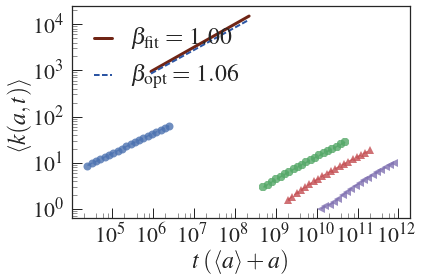

In [18]:
kat = DATA['pkt']

acts = np.array(DATA['Arrays']['Act'])
max_act = acts.max()
acts /= max_act
avg_act = acts.sum()/len(acts)
plt.figure()

Fit_X, Fit_Y = [], []
for superClass in sorted(selectedSuperClasses):
    # kat[act_class]
    degsFreqs = {}
    validKeys = [nodeClass for nodeClass in Pakt.keys() if currentSuperClass(nodeClass) == superClass]
    #print validKeys
    for nodeClass in validKeys:
        Res = Pakt[nodeClass]
        for time, Values in Res.iteritems():
            if time not in Times:
                continue
            for tmpDeg, tmpFreq in Values.iteritems():
                degsFreqs.setdefault(time, {"k": .0, "n": .0})
                degsFreqs[time]["k"] += tmpDeg*tmpFreq
                degsFreqs[time]["n"] += tmpFreq
                
    # Define something similar to mindeg to compute the avg act...
    act_tmp = avgAct(DATA, nodeClass, activityStr=activityString)
    
    X = np.array([float(DATA["TimeVecs"]["EventsT"][k]) for k, v in sorted(degsFreqs.items())])
    Y = np.array([v["k"]/v["n"] for k, v in sorted(degsFreqs.items())])
    
    X *= act_tmp + avg_act
    
    plt.loglog(X, Y, '--',\
               marker=markers[selectedSuperClasses.index(superClass)%len(markers)],\
               ms=8, alpha=.8, lw=1.5)#, label="%02d"%act_class)
    
    if superClass in selectedSuperClasses[classFrom:classTo]:
        Fit_X.extend(X[X>=fit_from])
        Fit_Y.extend(Y[X>=fit_from])

par_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth, x0=[1., .5, 1e-6],\
        args=(Fit_X, Fit_Y), bounds=[(1e-8, 1e+8), (0.025, .975), (.0, 1e-4)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)
plt.loglog(fit_plot_interval, .5*fit_offset*Power_Growth(par_out, fit_plot_interval), '-',\
           label=r"$\beta_{\rm fit}=%.02f$"%(1./par_out[1]-1.), color="#702515", lw=3)

par_out_theor, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth, x0=[1., 1./(1.+Beta_Opt), 1e-6],\
        args=(Fit_X, Fit_Y), bounds=[(1e-8, 1e+8), (1./(1.+Beta_Opt)*.9999, 1./(1.+Beta_Opt)*1.0001), (.0, 1e-4)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)
plt.loglog(fit_plot_interval, .55*fit_offset*Power_Growth(par_out_theor, fit_plot_interval), '--',\
           label=r"$\beta_{\rm opt}=%.02f$"%Beta_Opt, color="#2c55a3", lw=2)

plt.xticks(size=22)
plt.yticks(size=22)
plt.xlabel(r"$t \left(\langle a\rangle + a\right)$", size=24)
plt.ylabel(r"$\langle k(a,t)\rangle$", size=24)

if False:
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

plt.legend(loc=2, fontsize=24, ncol=1, handlelength=.75)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/kat_eve.pdf"), bbox_inches='tight')

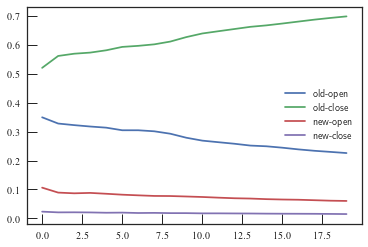

In [19]:
totEve_t = np.array(DATA["TimeVecs"]["newCloseTriang"]) + np.array(DATA["TimeVecs"]["newOpenTriang"])+\
          np.array(DATA["TimeVecs"]["oldOpenTriang"]) +  np.array(DATA["TimeVecs"]["oldCloseTriang"])

plt.plot(np.array(DATA["TimeVecs"]["oldOpenTriang"],dtype=float)/totEve_t, label="old-open")
plt.plot(np.array(DATA["TimeVecs"]["oldCloseTriang"],dtype=float)/totEve_t, label="old-close")
plt.plot(np.array(DATA["TimeVecs"]["newOpenTriang"],dtype=float)/totEve_t, label="new-open")
plt.plot(np.array(DATA["TimeVecs"]["newCloseTriang"],dtype=float)/totEve_t, label="new-close")

plt.legend()

In [20]:
"%s" % int(False)

'0'

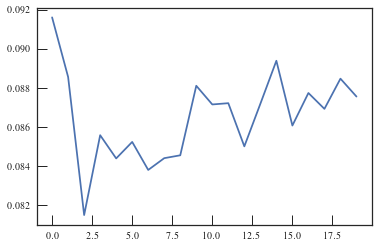

In [21]:
plt.plot(DATA["TimeVecs"]["Clust_t"])

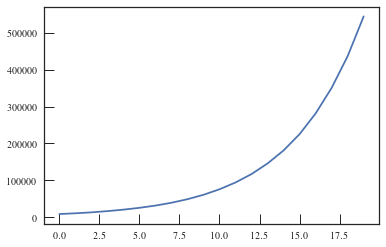

In [22]:
plt.plot(DATA["TimeVecs"]["NodesActiveT"])
#plt.plot(DATA["TimeVecs"]["EdgesActiveT"])

In [23]:
DATA["TimeVecs"]["Clust_t"]

[0.09163080084912802,
 0.08857438135195625,
 0.0814961999768424,
 0.08559100993014163,
 0.08440013158738134,
 0.08524599144255718,
 0.08380931544670382,
 0.08441306680733834,
 0.08456007936551047,
 0.08812474117549286,
 0.08716699319596002,
 0.0872319455907207,
 0.08501816069398485,
 0.08719977272022507,
 0.08940742307829265,
 0.08608571449592489,
 0.08775472035271573,
 0.08694066296765496,
 0.08848984828849277,
 0.08757267484122618]

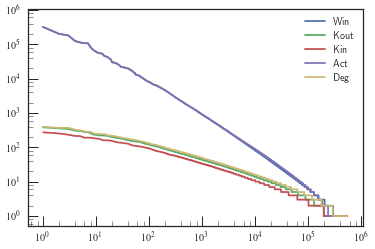

In [24]:
for what, arra in DATA["Arrays"].iteritems():
    if what in ["IDs", "Entr"]:
        continue
    plt.loglog(np.sort(arra)[::-1], label=what)
plt.legend()

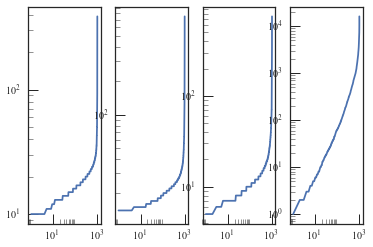

In [64]:
plt.subplot(1,4,1)
plt.loglog(np.sort(DATA["Arrays"]["Kin"]))
plt.subplot(1,4,2)
plt.loglog(np.sort(DATA["Arrays"]["Deg"]))
plt.subplot(1,4,3)
plt.loglog(np.sort(DATA["Arrays"]["Kout"]))
plt.subplot(1,4,4)
plt.loglog(np.sort(DATA["Arrays"]["Entr"]))

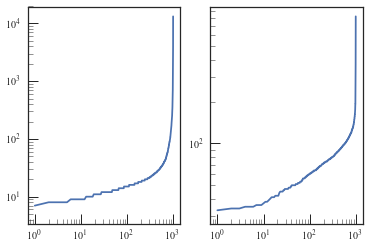

In [65]:
plt.subplot(1,2,1)
plt.loglog(np.sort(DATA["Arrays"]["Act"]))
plt.subplot(1,2,2)
plt.loglog(np.sort(DATA["Arrays"]["Win"]))

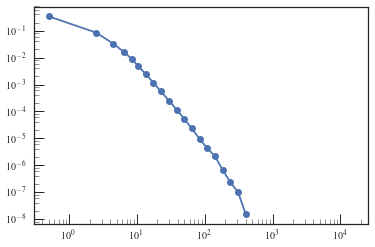

In [25]:
f, b = np.histogram(DATA["Arrays"]["Deg"], bins =Lin_Log_Bins(1, 20000, factor=1.3), density=True)
plt.loglog(b[:-1], f, "o-")

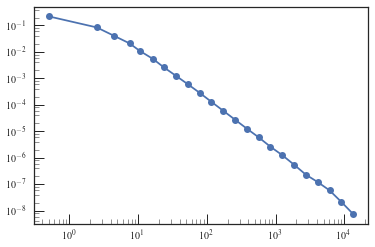

In [26]:
f, b = np.histogram(DATA["Arrays"]["Act"], bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
plt.loglog(b[:-1], f, "o-")

In [68]:
DATA["TimeVecs"]["RealTimeT"], DATA["TimeVecs"]["EventsT"]

([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [10000, 12916, 16682, 21545, 27826, 35939, 46416, 59949, 77427, 100000])

In [2]:
from Quick_Network import act_gen

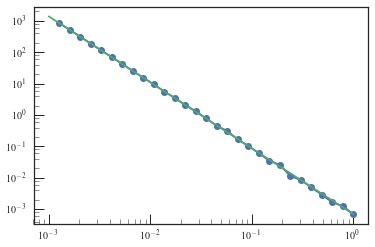

In [5]:
f, b = np.histogram(act_gen(100000, 1e-3, 1., 1.1), bins=np.logspace(-3, 0, 30), density=True)

plt.loglog(b[1:], f, "o-")
plt.loglog(np.logspace(-3, 0), .0007*np.logspace(-3, 0)**(-2.1))


In [ ]:
np.random.rand()

In [19]:
print np.min(Map_Rescaled), np.max(Map_Rescaled)

0.000190453839579 1.0


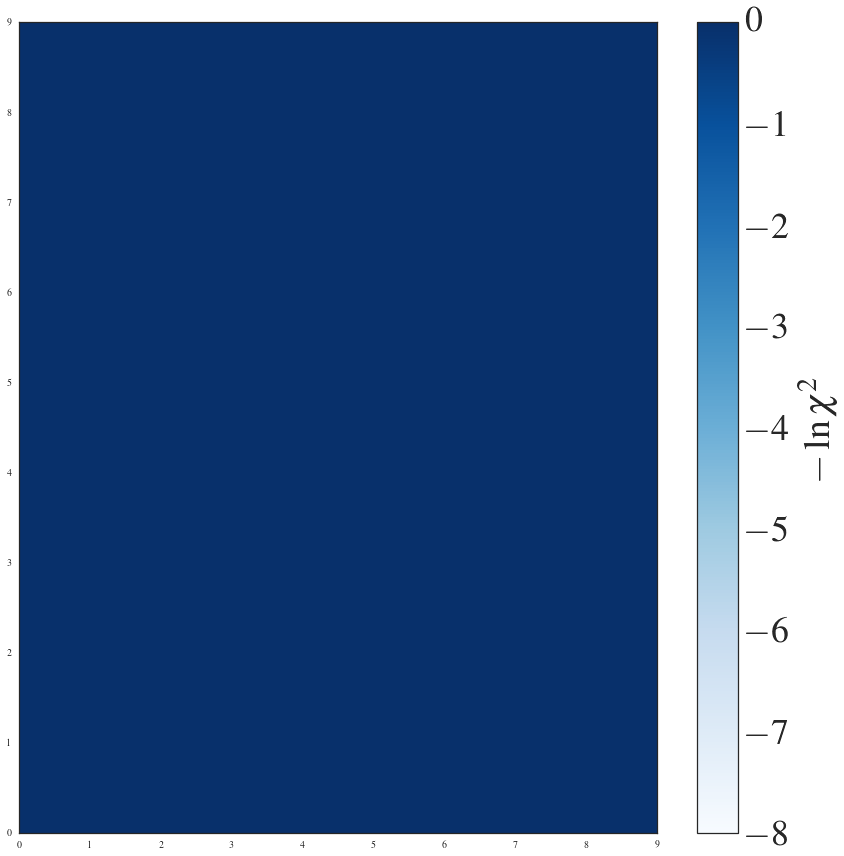

In [20]:
plt.figure(figsize=(12,12))

figHM = axHM.pcolormesh(Map_Rescaled, cmap='Blues', norm=Normalize(), edgecolors='none', shading='gouraud')
plt.pcolormesh(1./(np.random.rand(10,10)*DeltaVal+ValMin), cmap='Blues',\
               norm=Normalize(), edgecolors='none', shading='gouraud', vmin=.2, vmax=1.)
#plt.colorbar(ticks=np.linspace(1.0, 10.0))#, format="%.01f")

minimo = 8
cb = plt.colorbar(ticks=np.linspace(.2, 1.0, minimo+1))
font_size = 36 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)
cb.set_ticklabels([r"$%d$" %(-minimo+d) for d in range(minimo+1)])
cb.set_label(r"$-\ln{\chi^2}$", size=38)

plt.tight_layout()
plt.savefig("Colorbar.pdf", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(12,12))

plt.pcolormesh(Map_Rescaled, cmap='Blues', norm=Normalize(), edgecolors='none', shading='gouraud')
cb = plt.colorbar()
font_size = 36 # Adjust as appropriate.
cb.ax.tick_params(labelsize=font_size)
#cb.set_ticklabels([r"$%d$" %(-minimo+d) for d in range(minimo+1)])
cb.set_label(r"$\chi^2_{\rm opt}(b)/\chi^2_b(\beta)$", size=38)

plt.tight_layout()
plt.savefig("Colorbar.pdf", bbox_inches="tight")

In [ ]:
print cb.values

In [ ]:
X = np.logspace(0, np.log10(30), 60)
Y = np.linspace(1, 30, 59)
plt.loglog(X, Y, ".b")

X_m = X[1:] + X[:-1]
X_m /= 2.
plt.loglog(X_m, Y, "sk")

X_l = np.array([np.logspace(np.log10(X[i]), np.log10(X[i+1]), 5)[1] for i in range(len(X)-1)])
plt.loglog(X_l, Y, "*r")

In [ ]:
np.logspace(0,1,3)